In [1]:
import openmc
import numpy as np

In [2]:
BISO_KERNEL_RADIUS   = 0.04 # cm  # r = 400 μm = 0.0400 cm // "800 μm kernel"
BISO_RADIUS          = 0.05 # cm  # r = 500 μm = 0.0500 cm // "100 μm thickness"
BISO_VOLUME          = (4 / 3) * np.pi * (BISO_RADIUS)**3            # volume of single BISO particle
KERNEL_VOLUME        = (4 / 3) * np.pi * (BISO_KERNEL_RADIUS)**3     # volume of UO2/ThO2 kernel in single BISO particle
BISO_KERNEL_VOL_FRAC = KERNEL_VOLUME / BISO_VOLUME  # vol frac kernel in single BISO
BISO_COAT_VOL_FRAC   = 1.0 - BISO_KERNEL_VOL_FRAC

In [3]:
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=0.71)  
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.5)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.2)

# Lead-Lithium (Pb83at%-Li17at%)
pbli = openmc.Material(name='PbLi', temperature=900)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.1, enrichment_target='Li6', enrichment_type='wo', enrichment=90.0)
pbli.set_density('g/cm3', 9.5) 

# BISO
biso = openmc.Material.mix_materials([uo2, sic], [BISO_KERNEL_VOL_FRAC, BISO_COAT_VOL_FRAC], 'vo')
mix  = openmc.Material.mix_materials([pbli, biso], [0.5, 0.5], 'vo')

materials = openmc.Materials([uo2, sic, pbli, biso, mix])
materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

In [4]:
# Reflective cube boundaries 
cube_length = 1  # cm
cube_half   = cube_length / 2

x_min = openmc.XPlane(-cube_half, boundary_type='periodic')
x_max = openmc.XPlane( cube_half, boundary_type='periodic')
y_min = openmc.YPlane(-cube_half, boundary_type='periodic')
y_max = openmc.YPlane( cube_half, boundary_type='periodic')
z_min = openmc.ZPlane(-cube_half, boundary_type='periodic')
z_max = openmc.ZPlane( cube_half, boundary_type='periodic')
x_min.periodic_surface = x_max
y_min.periodic_surface = y_max
z_min.periodic_surface = z_max

# Homogeneous matrix
cell = openmc.Cell(name='mixture')
cell.fill = mix
cell.region = +x_min & -x_max & +y_min & -y_max & +z_min & -z_max

# Create universe and geometry
root_universe = openmc.Universe(cells=[cell])
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

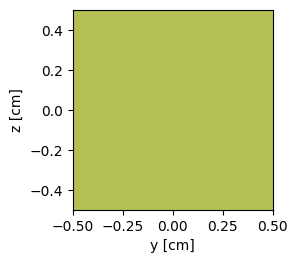

In [5]:
img = geometry.plot(basis='yz',                           # slice plane
                    width=(cube_length, cube_length),     # cm window
                    pixels=(200, 200),
                    color_by='material')

In [6]:
settings = openmc.Settings()

""" First wall neutron spectrum """
# Flux spectrum from neutrons leaving the surface of a 1-cm V first wall
sp = openmc.StatePoint(f'./FirstWall_V1cm_900K_2025-07-22/statepoint.100.h5')
out_tally = sp.get_tally(name='outgoing_spectrum')

energy_bins = np.array(out_tally.filters[1].bins) # shape (N, 2)
energy_midpoints = 0.5 * (energy_bins[:, 0] + energy_bins[:, 1])

current_spectrum = out_tally.get_values(scores=['current']).flatten() # Neutron generation at each current in the spectrum is weighted by its probability of occurrence
total_current = current_spectrum.sum()
probabilities = current_spectrum / total_current
energies, weights = energy_midpoints.tolist(), probabilities.tolist()

"""Source: 14 MeV"""
source = openmc.IndependentSource()
source.space = openmc.stats.Box([-1*cube_half, -1*cube_half, -1*cube_half], [cube_half, cube_half, cube_half])
source.particle = 'neutron'
source.constraints = {'fissionable': False}
source.energy = openmc.stats.Discrete(energies, weights) # openmc.stats.Discrete([14.0e6], [1.0])  # 14 MeV
# source.angle    = openmc.stats.Monodirectional((1, 0, 0))
source.angle = openmc.stats.Isotropic()


"""Settings"""
settings.run_mode  = "fixed source"
settings.batches   = 10
settings.particles = int(1e4)
settings.source    = [source]
settings.volume_normalized_flux_tallies = True
# settings.write_initial_source = True
# settings.sourcepoint = {'batches':[10],'write':True}

In [7]:
"""Tallies"""
tallies = openmc.Tallies()

# total rxn rates
t_tot = openmc.Tally(name="total rxn rates")
t_tot.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
tallies.append(t_tot)

# rxn rates by isotope
t_iso = openmc.Tally(name="rxn rates by isotope")
t_iso.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
t_iso.nuclides = ['U238', 'U235']
tallies.append(t_iso)

In [8]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./BISO_LL_homogeneous_50vol")
model.run(cwd="./BISO_LL_homogeneous_50vol") 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/mnt/c/MCNP/emma-openmc/Jupyter/BISO_LL_homogeneous_50vol/statepoint.10.h5')